In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import linkage, dendrogram

%matplotlib inline

In [2]:
df = pd.read_csv('kl.csv', encoding='ISO-8859-1')
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5M
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1M
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1M
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6M
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4M


In [3]:
df.shape

(18207, 89)

In [4]:
df.isnull().mean()

Unnamed: 0        0.000000
ID                0.000000
Name              0.000000
Age               0.000055
Photo             0.000000
                    ...   
GKHandling        0.002636
GKKicking         0.002636
GKPositioning     0.002636
GKReflexes        0.002636
Release Clause    0.085901
Length: 89, dtype: float64

<AxesSubplot:>

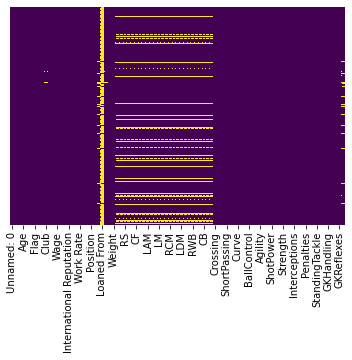

In [5]:
sns.heatmap(df.isna(), cmap='viridis', yticklabels=False, cbar=None)

In [6]:
def missing_values_boundry(df, missing_percentige):
    
    columns_with_missing_values_above_border = []
    series = df.isna().mean()
    for index in series.index:
        if series[index] > missing_percentige:
            columns_with_missing_values_above_border.append(index)
    return columns_with_missing_values_above_border
        
missing_values_boundry(df, 0.3)

['Loaned From']

In [7]:
df['Loaned From'].isna().mean()

0.9305761520294392

In [8]:
df.drop('Loaned From', axis=1, inplace=True)

In [9]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDivi

In [10]:
df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB', nan], dtype=object)

In [11]:
# podela promenljivih na numericke i kategoricke

numeric = []
categorical = []
for column in df.columns:
    if str(df[column].dtype) == 'object':
        categorical.append(column)
    else:
        numeric.append(column)
        
numeric
categorical

len(numeric) + len(categorical)
print('Broj kategorickih promenljivih:', len(categorical))
print('Broj numerickih promenljivih:', len(numeric))

Broj kategorickih promenljivih: 44
Broj numerickih promenljivih: 44


In [12]:
# zamena NaN vrednosti zeljenim metodom (mean, mode, median ili random sample imputation-om)

def impute_value(df, variable, method='random sample'):

    if method == 'mean':
        df[variable].fillna(df[variable].mean(), inplace=True)
    elif method == 'mode':
        df[variable].fillna(df[variable].mode()[0], inplace=True)
    elif method == 'median':
        df[variable + '_median'] = df[variable].fillna(df[variable].median())
    else:
        df[variable + '_random_sample'] = df[variable]
        random_sample = df[variable].dropna().sample(df[variable].isna().sum(), random_state=0)
        random_sample.index = df.loc[df[variable].isna()].index
        df.loc[df[variable].isna(), variable] = random_sample

In [13]:
def find_irq_outliers(values):
    
    outliers = []
    sorted_values = sorted(values)
    min, max = np.percentile(sorted_values, [25, 75])
    irq_difference = max - min
    upper_border = max + 1.5 * irq_difference
    lower_border = min - 1.5 * irq_difference

    for value in sorted_values:
        if value < lower_border or value > upper_border:
#         if upper_border < value < lower_border:
            outliers.append(value)
    return outliers
        
outlier_numeric_columns = []
for numerical_variable in numeric:
    if len(find_irq_outliers(df[numerical_variable])):
        outlier_numeric_columns.append(numerical_variable)

outlier_numeric_columns

['ID', 'Potential', 'Special']

In [14]:
for variable in numeric:
    if variable in outlier_numeric_columns:
        impute_value(df, variable, 'median')
        impute_value(df, variable)
        standard_deviation_old_values = df[variable].std()
        standard_deviation_median_values = df[variable + '_median'].std()
        standard_deviation_random_sample = df[variable + '_random_sample'].std()
        if abs(standard_deviation_median_values - standard_deviation_old_values) < abs(standard_deviation_random_sample - standard_deviation_old_values):
            df[variable] = df[variable + '_median']
        else:
            df[variable] = df[variable + '_random_sample']
        df.drop(columns=[variable + '_random_sample', variable + '_median'], inplace=True)

    else:
        impute_value(df, variable, 'mean')

In [15]:
for categorical_variable in categorical:
    impute_value(df, categorical_variable, 'mode')
sum(df[categorical].isna().sum().values)

0

In [16]:
sum(df[numeric].isna().sum().values)

0

<AxesSubplot:>

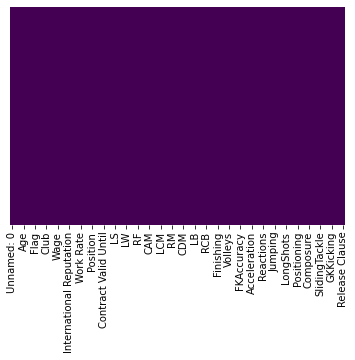

In [17]:
sns.heatmap(df.isna(), cmap='viridis', yticklabels=False, cbar=None)

In [18]:
# Funkcija koja vrsi skaliranje promenljivih zeljenom metodom

def feature_scaling(df, features, method):
    
    for feature in features:
        scaled_feature = method.fit_transform(df[[feature]])
        df[feature] = scaled_feature
        
feature_scaling(df, numeric, MinMaxScaler())

df[numeric].head()

,Unnamed: 0,ID,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,0.000000,0.640732,0.517241,1.000000,0.978723,0.910836,1.00,0.75,0.75,0.091837,...,0.804598,1.000000,0.329670,0.285714,0.261364,0.056180,0.109890,0.155556,0.146067,0.075269
1,0.000055,0.084285,0.586207,1.000000,0.978723,0.926935,1.00,0.75,1.00,0.061224,...,0.919540,0.989247,0.274725,0.318681,0.227273,0.067416,0.109890,0.155556,0.146067,0.107527
2,0.000110,0.773933,0.344828,0.958333,0.957447,0.874303,1.00,1.00,1.00,0.091837,...,0.873563,0.978495,0.263736,0.241758,0.340909,0.089888,0.087912,0.155556,0.157303,0.107527
3,0.000165,0.782891,0.379310,0.937500,0.957447,0.458204,0.75,0.50,0.00,0.000000,...,0.402299,0.698925,0.131868,0.208791,0.113636,1.000000,0.923077,0.955556,0.977528,1.000000
4,0.000220,0.782506,0.379310,0.937500,0.936170,0.959752,0.75,1.00,0.75,0.061224,...,0.850575,0.913978,0.714286,0.615385,0.545455,0.157303,0.131868,0.044444,0.101124,0.129032


In [19]:
df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

**Golman** - GK

**Odbrana** - RWB, RB, RCB, CB, LCB, LB, LWB

**Vezni red** - RDM, CDM, LDM, RM, RCM, CM, LCM, LM, RAM, CAM, LAM

**Napad** - RF, CF, LF, RS, ST, LS, LW, RW

In [20]:
def show_position_percentige_per_cluster(df, cluster_number, original_dataset_length):
    
    number_of_players_in_cluster = len(df)
    print(f'Broj igraca u klasteru {cluster_number}: {number_of_players_in_cluster}, ({(number_of_players_in_cluster / original_dataset_length) * 100} %)' )
    print()

    # Napad
    
    df_num_of_attackers = len(df.loc[(df['Position'] == 'RF') | (df['Position'] == 'LF') | (df['Position'] == 'RW') | (df['Position'] == 'LW') | (df['Position'] == 'ST') | (df['Position'] =='CF') |  (df['Position'] == 'RS') | (df['Position'] == 'LS')])
    df_num_of_attackers_percentige = (df_num_of_attackers / number_of_players_in_cluster) * 100

    print(f'NAPAD: {df_num_of_attackers} ({df_num_of_attackers_percentige} %)')
    rf_number = len(df.loc[df['Position'] == 'RF'])
    rf_percentige = (rf_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RF:', f'{rf_number}, ({rf_percentige} %)')
    lf_number = len(df.loc[df['Position'] == 'LF'])
    lf_percentige = (lf_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LF:', f'{lf_number}, ({lf_percentige} %)')
    rw_number = len(df.loc[df['Position'] == 'RW'])
    rw_percentige = (rw_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RW:', f'{rw_number}, ({rw_percentige} %)')
    lw_number = len(df.loc[df['Position'] == 'LW'])
    lw_percentige = (lw_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LW:', f'{lw_number}, ({lw_percentige} %)')
    st_number = len(df.loc[df['Position'] == 'ST'])
    st_percentige = (st_number / number_of_players_in_cluster ) * 100
    print('Broj igraca na poziciji ST:', f'{st_number}, ({st_percentige} %)')
    cf_number = len(df.loc[df['Position'] == 'CF'])
    cf_percentige = (cf_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji CF:', f'{cf_number}, ({cf_percentige} %)')
    rs_number = len(df.loc[df['Position'] == 'RS'])
    rs_percentige = (rs_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RS:', f'{rs_number}, ({rs_percentige} %)')
    ls_number = len(df.loc[df['Position'] == 'LS'])
    ls_percentige = (ls_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LS:', f'{ls_number}, ({ls_percentige} %)')
    print()

    # Vezni red

    df_num_of_mid = len(df.loc[(df['Position'] == 'RDM') | (df['Position'] == 'CDM') | (df['Position'] == 'LDM') | (df['Position'] == 'RM') | (df['Position'] == 'RCM') | (df['Position'] == 'CM') | (df['Position'] == 'LCM') | (df['Position'] == 'LM') | (df['Position'] == 'RAM') | (df['Position'] == 'CAM') | (df['Position'] =='LAM')])
    df_num_of_mid_percentige = (df_num_of_mid / number_of_players_in_cluster) * 100

    print(f'VEZNI RED: {df_num_of_mid} ({df_num_of_mid_percentige} %)')
    rdm_number = len(df.loc[df['Position'] == 'RDM'])
    rdm_percentige = (rdm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RDM:', f'{rdm_number}, ({rdm_percentige} %)')
    cdm_number = len(df.loc[df['Position'] == 'CDM'])
    cdm_percentige = (cdm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji CDM:', f'{cdm_number}, ({cdm_percentige} %)')
    ldm_number = len(df.loc[df['Position'] == 'LDM'])
    ldm_percentige = (ldm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LDM:', f'{ldm_number}, ({ldm_percentige} %)')
    rm_number = len(df.loc[df['Position'] == 'RM'])
    rm_percentige = (rm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RM:', f'{rm_number}, ({rm_percentige} %)')
    rcm_number = len(df.loc[df['Position'] == 'RCM'])
    rcm_percentige = (rcm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RCM:', f'{rcm_number}, ({rcm_percentige} %)')
    cm_number = len(df.loc[df['Position'] == 'CM'])
    cm_percentige = (cm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji CM:', f'{cm_number}, ({cm_percentige} %)')
    lcm_number = len(df.loc[df['Position'] == 'LCM'])
    lcm_percentige = (lcm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LCM:', f'{lcm_number}, ({lcm_percentige} %)')
    lm_number = len(df.loc[df['Position'] == 'LM'])
    lm_percentige = (lm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LM:', f'{lm_number}, ({lm_percentige} %)')
    ram_number = len(df.loc[df['Position'] == 'RAM'])
    ram_percentige = (ram_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RAM:', f'{ram_number}, ({ram_percentige} %)')
    cam_number = len(df.loc[df['Position'] == 'CAM'])
    cam_percentige = (cam_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji CAM:', f'{cam_number}, ({cam_percentige} %)')
    lam_number = len(df.loc[df['Position'] == 'LAM'])
    lam_percentige = (lam_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LAM:', f'{lam_number}, ({lam_percentige} %)')
    print()

    # Odbrana

    df_num_of_dif = len(df.loc[(df['Position'] == 'RWB') | (df['Position'] == 'RB') | (df['Position'] == 'RCB') | (df['Position'] == 'CB') | (df['Position'] == 'LCB') | (df['Position'] == 'LB') | (df['Position'] == 'LWB')])
    df_num_of_dif_percentige = (df_num_of_dif / number_of_players_in_cluster) * 100

    print(f'ODBRANA: {df_num_of_dif} ({df_num_of_dif_percentige} %)')
    rwb_number = len(df.loc[df['Position'] == 'RWB'])
    rwb_percentige = (rwb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RWB:', f'{rwb_number}, ({rwb_percentige} %)')
    rb_number = len(df.loc[df['Position'] == 'RB'])
    rb_percentige = (rb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RB:', f'{rb_number}, ({rb_percentige} %)')
    rcb_number = len(df.loc[df['Position'] == 'RCB'])
    rcb_percentige = (rcb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RCB:', f'{rcb_number}, ({rcb_percentige} %)')
    cb_number = len(df.loc[df['Position'] == 'CB'])
    cb_percentige = (cb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji CB:', f'{cb_number}, ({cb_percentige} %)')
    lcb_number = len(df.loc[df['Position'] == 'LCB'])
    lcb_percentige = (lcb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LCB:', f'{lcb_number}, ({lcb_percentige} %)')
    lb_number = len(df.loc[df['Position'] == 'LB'])
    lb_percentige = (lb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LB:', f'{lb_number}, ({lb_percentige} %)')
    lwb_number = len(df.loc[df['Position'] == 'LWB'])
    lwb_percentige = (lwb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LWB:', f'{lwb_number}, ({lwb_percentige} %)')
    print()

    # Golmani

    df_num_of_gk = len(df.loc[df['Position'] == 'GK'])
    df_num_of_gk_percentige = (df_num_of_gk / number_of_players_in_cluster) * 100
    
    print(f'GOLMANI: {df_num_of_gk} ({df_num_of_gk_percentige} %)')
    print()

In [21]:
from collections import Counter

sse = []
silhouette = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[numeric])
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df[numeric], kmeans.labels_))
    


Text(0, 0.5, 'SSE')

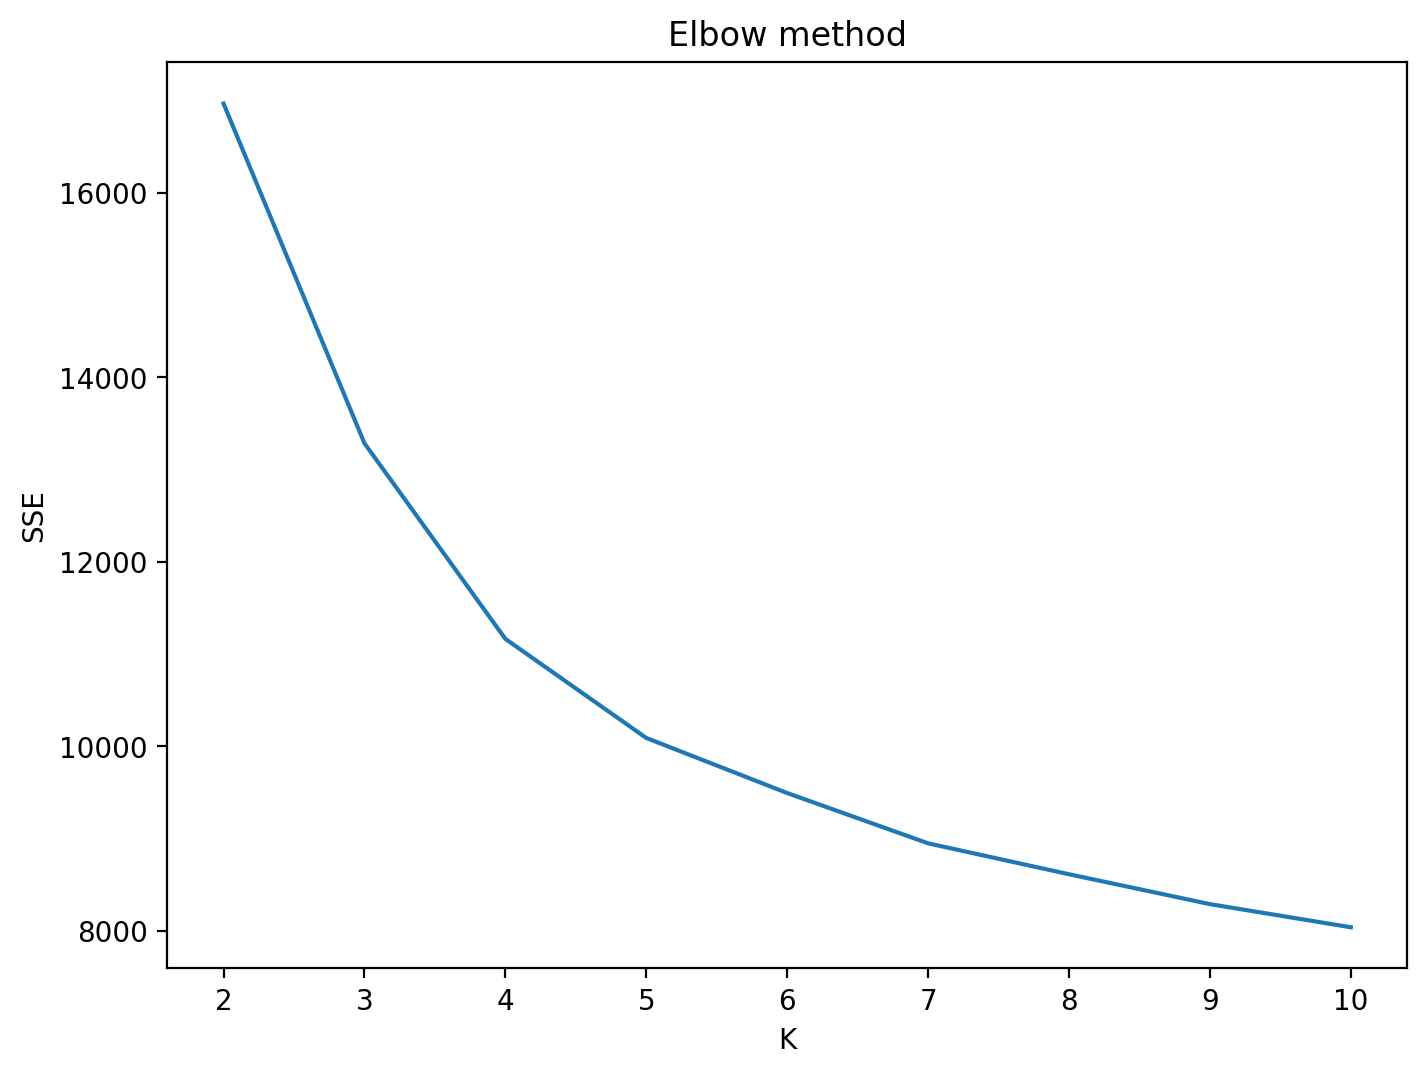

In [22]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
plt.plot(range(2, 11), sse)
plt.title('Elbow method')
plt.xlabel('K')
plt.ylabel('SSE')

In [23]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df[numeric])
kmeans.labels_

count = Counter(kmeans.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{3: [5891, 32.35568737298841],
 1: [5537, 30.411380238369855],
 0: [4753, 26.105344098423682],
 2: [2026, 11.127588290218048]}

In [24]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))

Broj igraca u klasteru 0: 4753, (26.105344098423682 %)

NAPAD: 2542 (53.482011361245526 %)
Broj igraca na poziciji RF: 5, (0.1051967178624027 %)
Broj igraca na poziciji LF: 7, (0.14727540500736377 %)
Broj igraca na poziciji RW: 248, (5.217757205975174 %)
Broj igraca na poziciji LW: 260, (5.47022932884494 %)
Broj igraca na poziciji ST: 1716, (36.103513570376606 %)
Broj igraca na poziciji CF: 50, (1.0519671786240268 %)
Broj igraca na poziciji RS: 128, (2.6930359772775088 %)
Broj igraca na poziciji LS: 128, (2.6930359772775088 %)

VEZNI RED: 2173 (45.71849358300021 %)
Broj igraca na poziciji RDM: 11, (0.23143277929728595 %)
Broj igraca na poziciji CDM: 7, (0.14727540500736377 %)
Broj igraca na poziciji LDM: 10, (0.2103934357248054 %)
Broj igraca na poziciji RM: 624, (13.128550389227856 %)
Broj igraca na poziciji RCM: 34, (0.7153376814643384 %)
Broj igraca na poziciji CM: 305, (6.416999789606565 %)
Broj igraca na poziciji LCM: 40, (0.8415737428992216 %)
Broj igraca na poziciji LM: 621, (13

In [25]:
player = df_cluster_2.loc[df_cluster_2['Position'] == 'ST']
player

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,cluster_marks
16450,0.903548,0.786261,S. Paul,0.517241,https://cdn.sofifa.org/players/4/19/193911.png,India,https://cdn.sofifa.org/flags/159.png,0.229167,0.191489,AS Monaco,...,0.098901,0.142857,0.102273,0.58427,0.516484,0.677778,0.629213,0.634409,1.1M,2


In [26]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

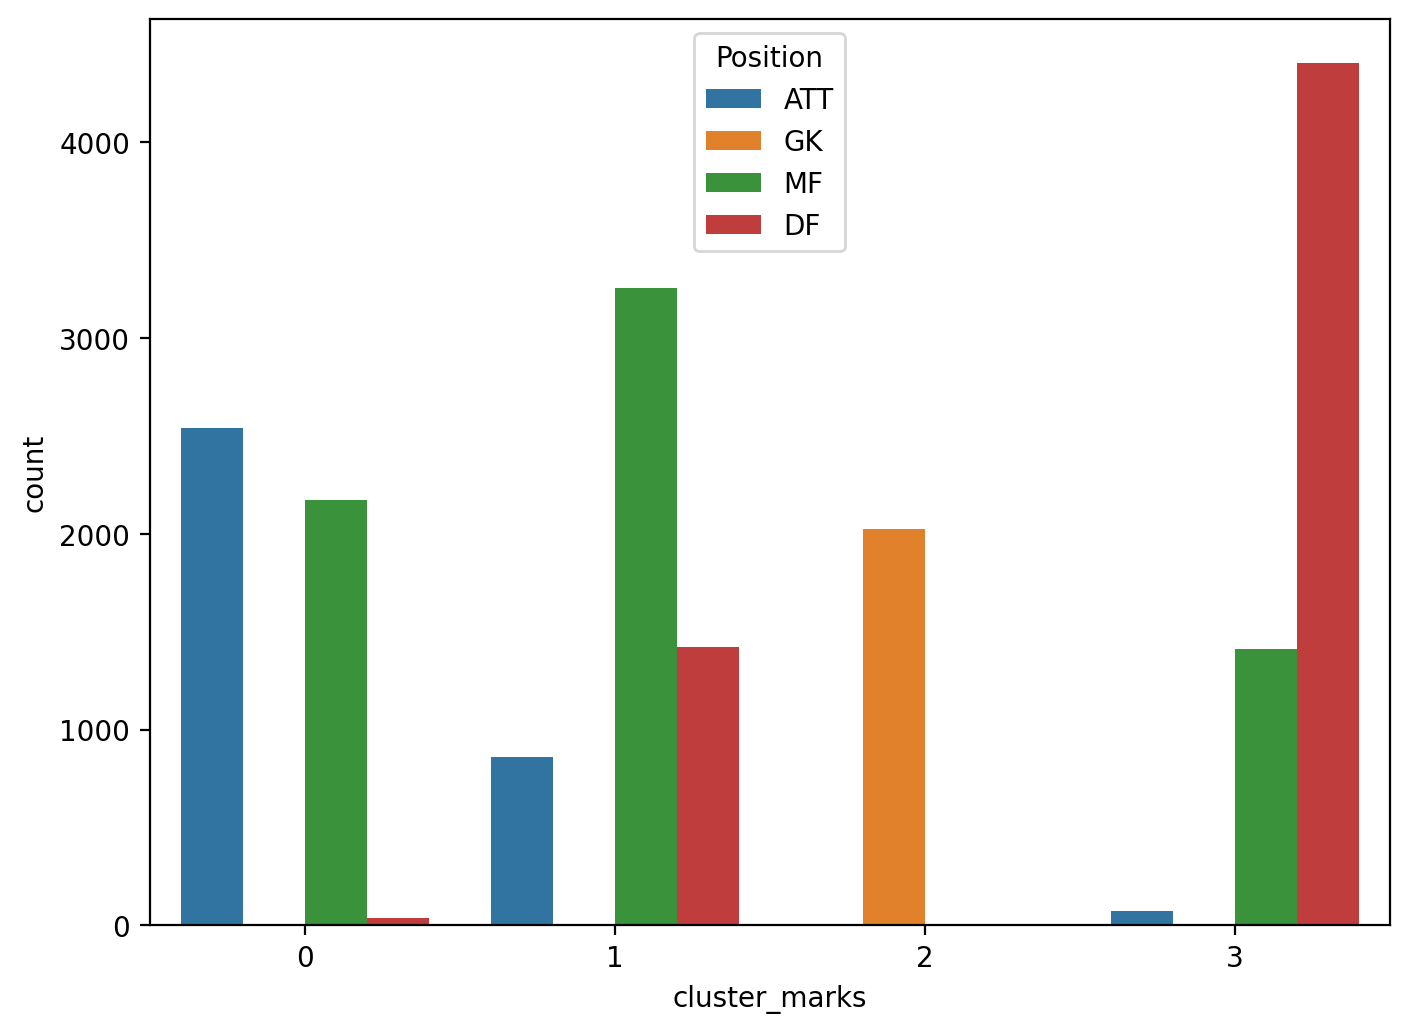

In [27]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

Text(0, 0.5, 'Silhouette score')

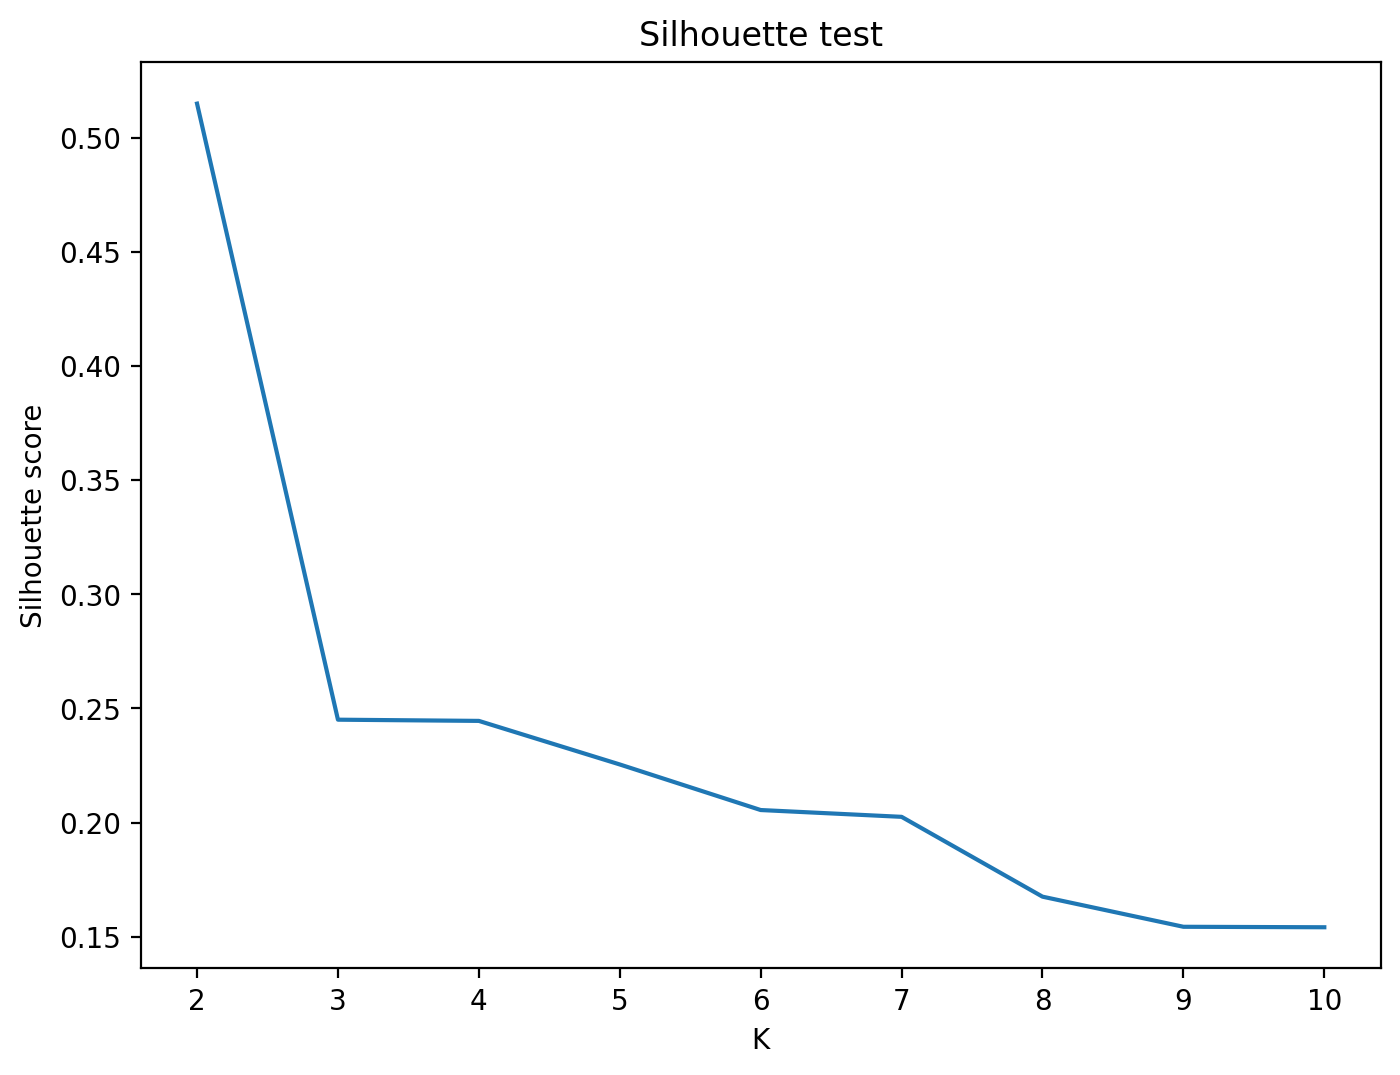

In [28]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
plt.plot(range(2, 11), silhouette)
plt.title('Silhouette test')
plt.xlabel('K')
plt.ylabel('Silhouette score')

In [29]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(df[numeric])
kmeans.labels_

count = Counter(kmeans.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]

number_and_percentige_per_cluster    

{0: [16180, 88.8669193167463], 1: [2027, 11.133080683253693]}

In [30]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))

Broj igraca u klasteru 0: 16180, (88.8669193167463 %)

NAPAD: 3477 (21.489493201483313 %)
Broj igraca na poziciji RF: 16, (0.0988875154511743 %)
Broj igraca na poziciji LF: 15, (0.0927070457354759 %)
Broj igraca na poziciji RW: 370, (2.2867737948084055 %)
Broj igraca na poziciji LW: 381, (2.3547589616810876 %)
Broj igraca na poziciji ST: 2211, (13.665018541409147 %)
Broj igraca na poziciji CF: 74, (0.4573547589616811 %)
Broj igraca na poziciji RS: 203, (1.254635352286774 %)
Broj igraca na poziciji LS: 207, (1.2793572311495673 %)

VEZNI RED: 6838 (42.26205191594561 %)
Broj igraca na poziciji RDM: 248, (1.5327564894932013 %)
Broj igraca na poziciji CDM: 948, (5.859085290482077 %)
Broj igraca na poziciji LDM: 243, (1.5018541409147095 %)
Broj igraca na poziciji RM: 1124, (6.946847960444994 %)
Broj igraca na poziciji RCM: 391, (2.4165636588380717 %)
Broj igraca na poziciji CM: 1394, (8.615574783683561 %)
Broj igraca na poziciji LCM: 395, (2.4412855377008653 %)
Broj igraca na poziciji LM: 10

In [31]:
player = df_cluster_1.loc[df_cluster_1['Position'] == 'ST']
player

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,cluster_marks
16450,0.903548,0.786261,S. Paul,0.517241,https://cdn.sofifa.org/players/4/19/193911.png,India,https://cdn.sofifa.org/flags/159.png,0.229167,0.191489,AS Monaco,...,0.098901,0.142857,0.102273,0.58427,0.516484,0.677778,0.629213,0.634409,1.1M,1


In [32]:
player = df_cluster_1.loc[df_cluster_1['Position'] == 'CB']
player

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,cluster_marks
17657,0.969845,0.046285,J. McCombe,0.655172,https://cdn.sofifa.org/players/4/19/11430.png,England,https://cdn.sofifa.org/flags/14.png,0.145833,0.106383,Lincoln City,...,0.527473,0.538462,0.568182,0.05618,0.142857,0.122222,0.11236,0.139785,18K,1


In [33]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

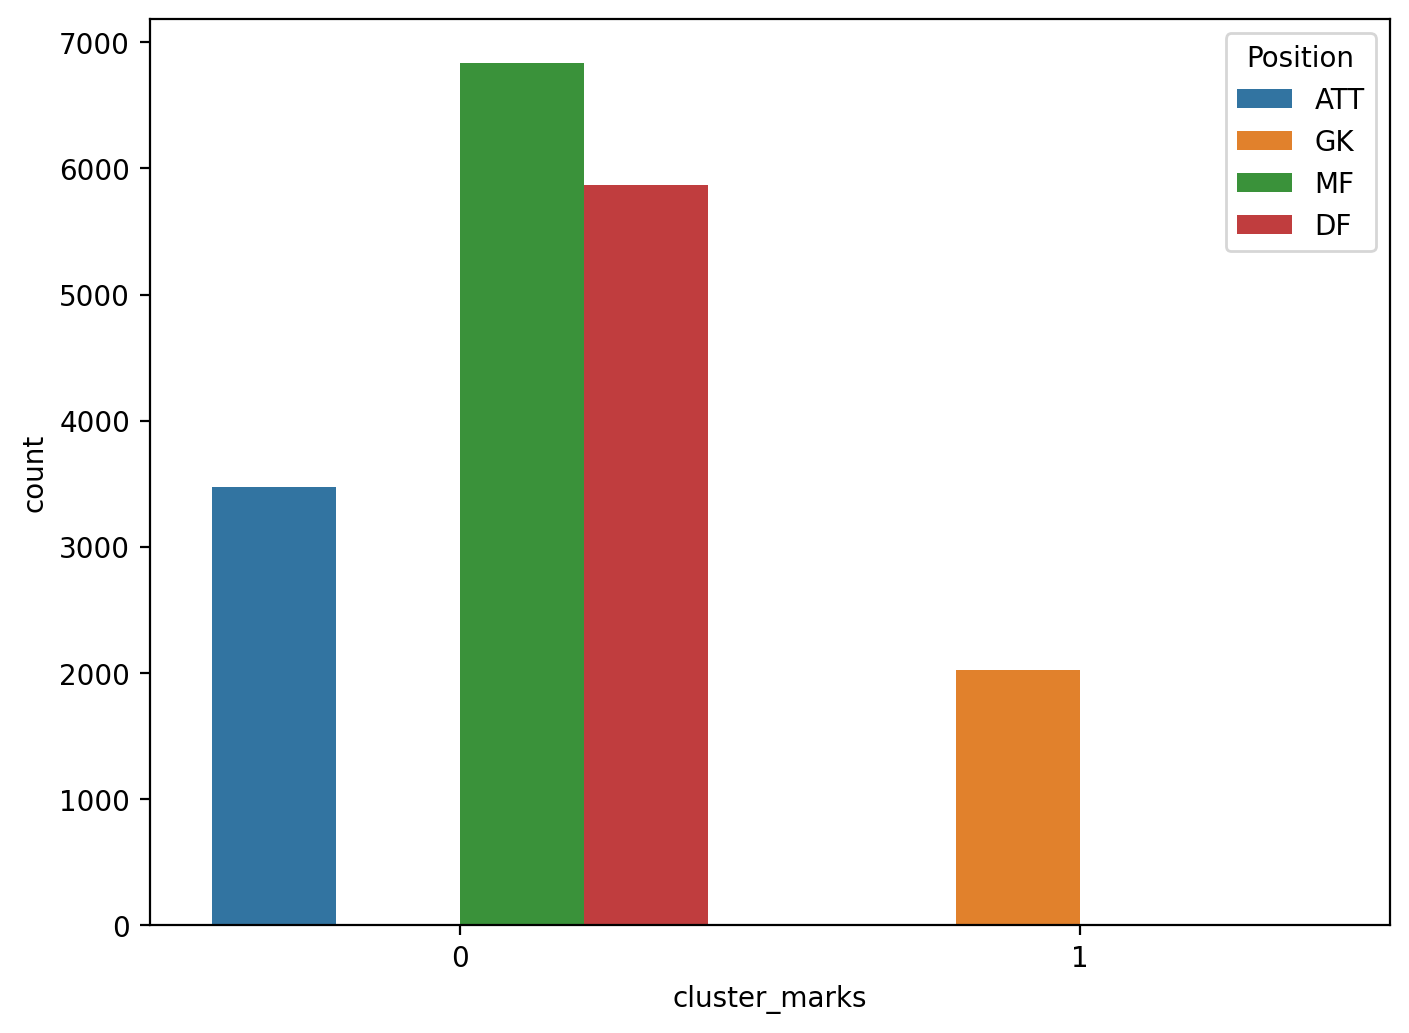

In [34]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [35]:
# Koristiti domensko znanje...
# Ukoliko znamo da se svaka pozicija (odbrana, vezni red i napad) moze podeliti na...
# ... podpozicije, dolazimo na 27 razlicitih podpozicija
# Pokusati za k=27

kmeans = KMeans(n_clusters=27, random_state=0)
kmeans.fit(df[numeric])
kmeans.labels_

count = Counter(kmeans.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{11: [1048, 5.756027901356621],
 24: [1000, 5.49239303564563],
 23: [935, 5.135387488328664],
 2: [903, 4.959630911188005],
 6: [901, 4.9486461251167135],
 3: [880, 4.833305871368155],
 8: [865, 4.750919975833471],
 15: [858, 4.712473224583951],
 0: [824, 4.525731861372],
 12: [709, 3.8941066622727525],
 19: [706, 3.8776294831658156],
 21: [698, 3.8336903388806505],
 18: [673, 3.6963805129895095],
 7: [670, 3.6799033338825726],
 26: [667, 3.6634261547756357],
 4: [624, 3.4272532542428733],
 20: [614, 3.3723293238864174],
 13: [532, 2.9219530949634756],
 10: [527, 2.8944911297852474],
 22: [526, 2.8889987367496017],
 1: [484, 2.6583182292524854],
 25: [480, 2.636348657109903],
 9: [462, 2.5374855824682814],
 17: [458, 2.515516010325699],
 16: [402, 2.2079420003295436],
 5: [401, 2.202449607293898],
 14: [360, 1.9772614928324272]}

In [36]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]
df_cluster_5 = df.loc[df['cluster_marks'] == 5]
df_cluster_6 = df.loc[df['cluster_marks'] == 6]
df_cluster_7 = df.loc[df['cluster_marks'] == 7]
df_cluster_8 = df.loc[df['cluster_marks'] == 8]
df_cluster_9 = df.loc[df['cluster_marks'] == 9]
df_cluster_10 = df.loc[df['cluster_marks'] == 10]
df_cluster_11 = df.loc[df['cluster_marks'] == 11]
df_cluster_12 = df.loc[df['cluster_marks'] == 12]
df_cluster_13 = df.loc[df['cluster_marks'] == 13]
df_cluster_14 = df.loc[df['cluster_marks'] == 14]
df_cluster_15 = df.loc[df['cluster_marks'] == 15]
df_cluster_16 = df.loc[df['cluster_marks'] == 16]
df_cluster_17 = df.loc[df['cluster_marks'] == 17]
df_cluster_18 = df.loc[df['cluster_marks'] == 18]
df_cluster_19 = df.loc[df['cluster_marks'] == 19]
df_cluster_20 = df.loc[df['cluster_marks'] == 20]
df_cluster_21 = df.loc[df['cluster_marks'] == 21]
df_cluster_22 = df.loc[df['cluster_marks'] == 22]
df_cluster_23 = df.loc[df['cluster_marks'] == 23]
df_cluster_24 = df.loc[df['cluster_marks'] == 24]
df_cluster_25 = df.loc[df['cluster_marks'] == 25]
df_cluster_26 = df.loc[df['cluster_marks'] == 26]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))
show_position_percentige_per_cluster(df_cluster_5, 5, len(df))
show_position_percentige_per_cluster(df_cluster_6, 6, len(df))
show_position_percentige_per_cluster(df_cluster_7, 7, len(df))
show_position_percentige_per_cluster(df_cluster_8, 8, len(df))
show_position_percentige_per_cluster(df_cluster_9, 9, len(df))
show_position_percentige_per_cluster(df_cluster_10, 10, len(df))
show_position_percentige_per_cluster(df_cluster_11, 11, len(df))
show_position_percentige_per_cluster(df_cluster_12, 12, len(df))
show_position_percentige_per_cluster(df_cluster_13, 13, len(df))
show_position_percentige_per_cluster(df_cluster_14, 14, len(df))
show_position_percentige_per_cluster(df_cluster_15, 15, len(df))
show_position_percentige_per_cluster(df_cluster_16, 16, len(df))
show_position_percentige_per_cluster(df_cluster_17, 17, len(df))
show_position_percentige_per_cluster(df_cluster_18, 18, len(df))
show_position_percentige_per_cluster(df_cluster_19, 19, len(df))
show_position_percentige_per_cluster(df_cluster_20, 20, len(df))
show_position_percentige_per_cluster(df_cluster_21, 12, len(df))
show_position_percentige_per_cluster(df_cluster_22, 22, len(df))
show_position_percentige_per_cluster(df_cluster_23, 23, len(df))
show_position_percentige_per_cluster(df_cluster_24, 24, len(df))
show_position_percentige_per_cluster(df_cluster_24, 25, len(df))
show_position_percentige_per_cluster(df_cluster_26, 26, len(df))

Broj igraca u klasteru 0: 824, (4.525731861372 %)

NAPAD: 1 (0.12135922330097086 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 1, (0.12135922330097086 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 8 (1.1283497884344147 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 5, (0.7052186177715092 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 2, (0.2820874471086037 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 1, (0.14104372355430184 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 701 (98.8716502115656 %)
Broj igraca na poziciji RWB: 1, (0.14104372355430184 %)
Broj igraca na poziciji RB: 8, (1.1283497884344147 %)
Broj i

ODBRANA: 125 (12.5 %)
Broj igraca na poziciji RWB: 7, (0.7000000000000001 %)
Broj igraca na poziciji RB: 41, (4.1000000000000005 %)
Broj igraca na poziciji RCB: 3, (0.3 %)
Broj igraca na poziciji CB: 1, (0.1 %)
Broj igraca na poziciji LCB: 1, (0.1 %)
Broj igraca na poziciji LB: 65, (6.5 %)
Broj igraca na poziciji LWB: 7, (0.7000000000000001 %)

GOLMANI: 0 (0.0 %)

Broj igraca u klasteru 25: 1000, (5.49239303564563 %)

NAPAD: 80 (8.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 1, (0.1 %)
Broj igraca na poziciji RW: 21, (2.1 %)
Broj igraca na poziciji LW: 33, (3.3000000000000003 %)
Broj igraca na poziciji ST: 20, (2.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 3, (0.3 %)
Broj igraca na poziciji LS: 2, (0.2 %)

VEZNI RED: 795 (79.5 %)
Broj igraca na poziciji RDM: 15, (1.5 %)
Broj igraca na poziciji CDM: 40, (4.0 %)
Broj igraca na poziciji LDM: 20, (2.0 %)
Broj igraca na poziciji RM: 124, (12.4 %)
Broj igraca na poziciji RCM: 54, (5.4 %)

In [37]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

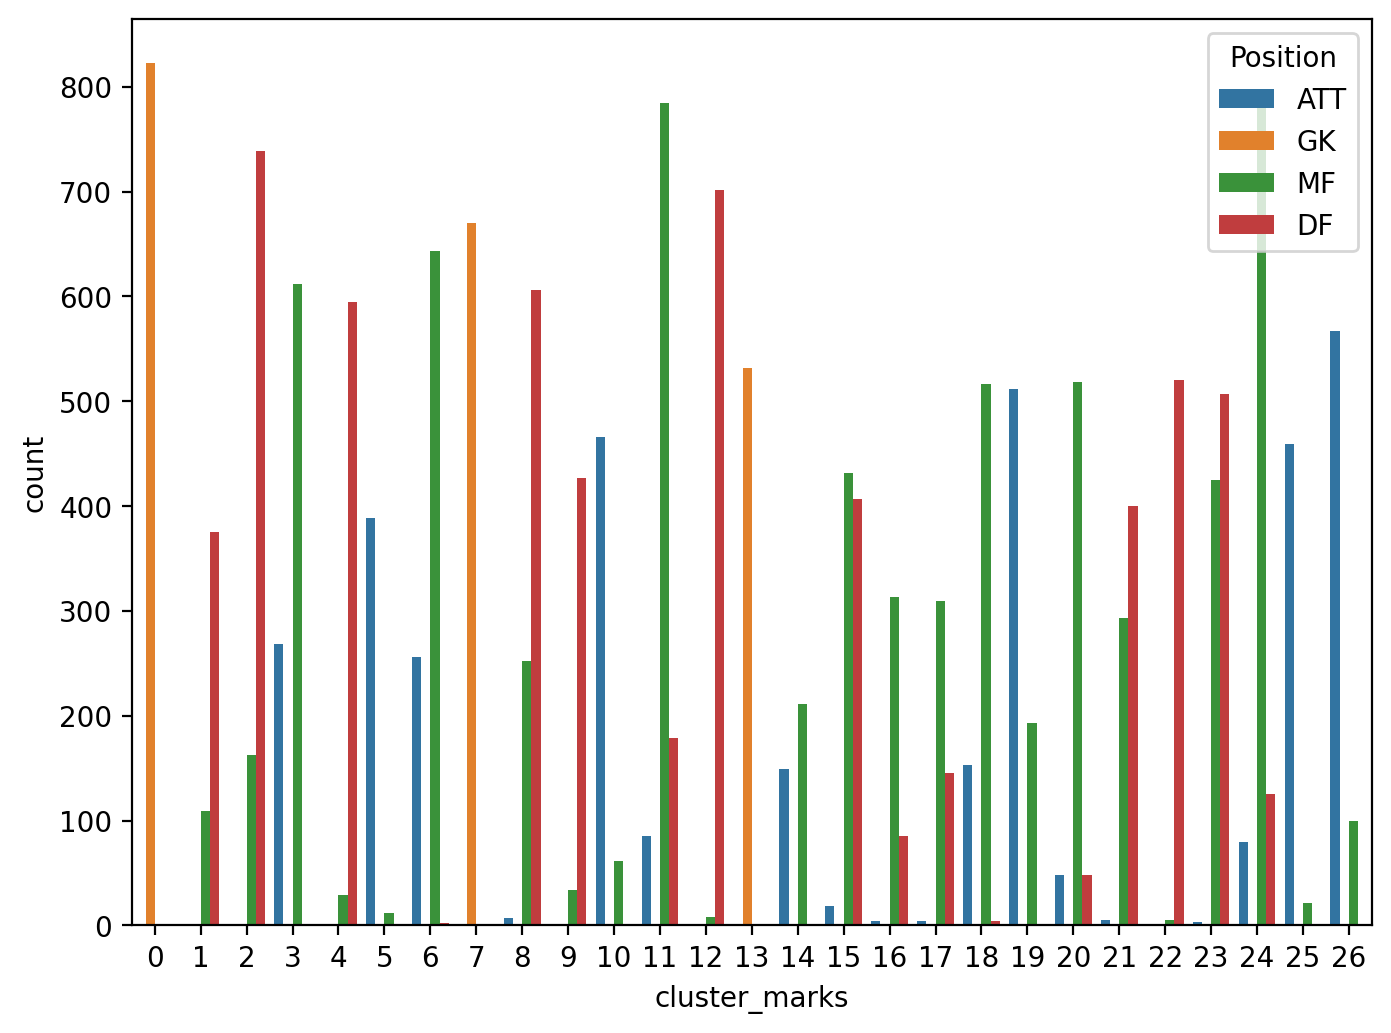

In [38]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [39]:
categorical_features_index = []
for index, feature in enumerate(df.columns.values):
    if str(df[feature].dtype) == 'object':
        categorical_features_index.append(index)

In [40]:
# KPrototypes

sse = []

for k in range(2, 11):
    kprototypes = KPrototypes(n_clusters=k, random_state=0, n_jobs=-1)
    kprototypes.fit(df, categorical=categorical_features_index)
    sse.append(kprototypes.cost_)

Text(0, 0.5, 'Cost')

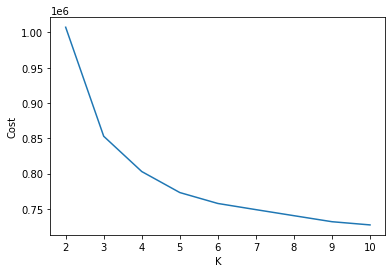

In [41]:
plt.plot(range(2, 11), sse)
plt.xlabel('K')
plt.ylabel('Cost')

In [42]:
kprototypes = KPrototypes(n_clusters=4, random_state=0)
kprototypes.fit(df, categorical=categorical_features_index)

KPrototypes(gamma=1.0956456863112687, n_clusters=4, random_state=0)

In [43]:
count = Counter(kprototypes.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{0: [5687, 31.2352391937167],
 1: [4310, 23.67221398363267],
 2: [4156, 22.826385456143242],
 3: [4054, 22.266161366507387]}

In [44]:
df['cluster_marks'] = kprototypes.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))

Broj igraca u klasteru 0: 5687, (31.2352391937167 %)

NAPAD: 915 (16.089326534200808 %)
Broj igraca na poziciji RF: 4, (0.0703358537014243 %)
Broj igraca na poziciji LF: 6, (0.10550378055213644 %)
Broj igraca na poziciji RW: 174, (3.059609636011957 %)
Broj igraca na poziciji LW: 182, (3.2002813434148054 %)
Broj igraca na poziciji ST: 427, (7.508352382627044 %)
Broj igraca na poziciji CF: 23, (0.4044311587831897 %)
Broj igraca na poziciji RS: 50, (0.8791981712678038 %)
Broj igraca na poziciji LS: 49, (0.8616142078424477 %)

VEZNI RED: 1568 (27.571654650958326 %)
Broj igraca na poziciji RDM: 45, (0.7912783541410234 %)
Broj igraca na poziciji CDM: 160, (2.813434148056972 %)
Broj igraca na poziciji LDM: 35, (0.6154387198874627 %)
Broj igraca na poziciji RM: 417, (7.3325127483734835 %)
Broj igraca na poziciji RCM: 26, (0.45718304905925794 %)
Broj igraca na poziciji CM: 45, (0.7912783541410234 %)
Broj igraca na poziciji LCM: 47, (0.8264462809917356 %)
Broj igraca na poziciji LM: 422, (7.4204

In [45]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

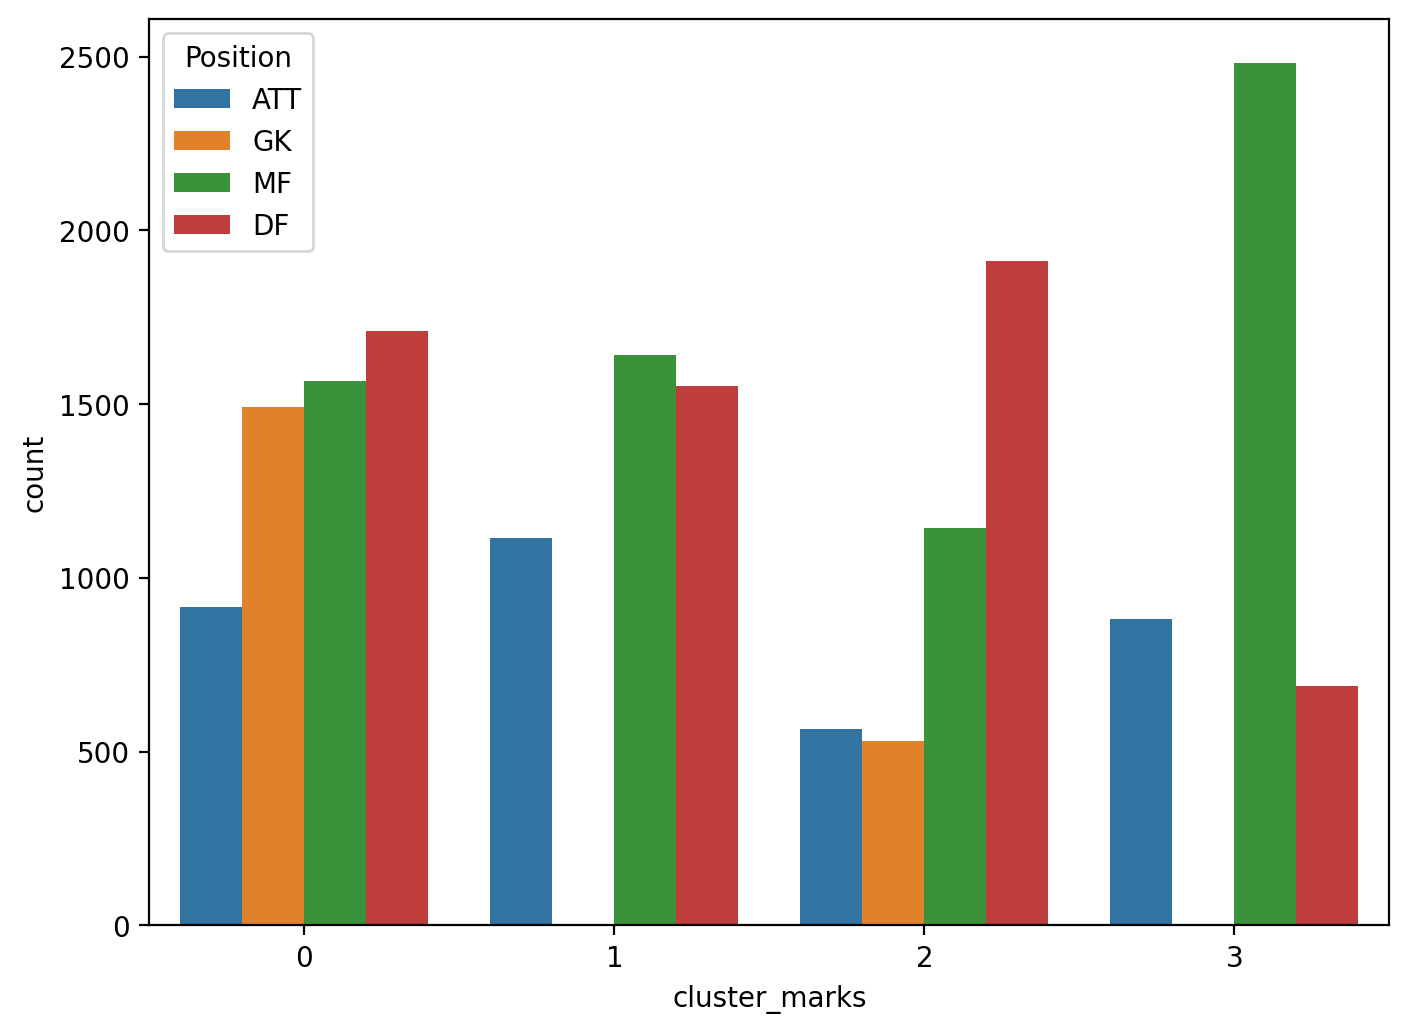

In [46]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [47]:
kprototypes = KPrototypes(n_clusters=27, random_state=0)
kprototypes.fit(df, categorical=categorical_features_index)

count = Counter(kprototypes.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{19: [1003, 5.508870214752568],
 10: [915, 5.0255396276157525],
 9: [903, 4.959630911188005],
 22: [866, 4.756412368869116],
 24: [839, 4.608117756906684],
 14: [832, 4.569671005657165],
 23: [811, 4.454330751908606],
 13: [778, 4.273081781732301],
 16: [745, 4.091832811555995],
 17: [744, 4.086340418520349],
 4: [698, 3.8336903388806505],
 21: [685, 3.762289229417257],
 11: [685, 3.762289229417257],
 26: [679, 3.7293348712033834],
 3: [672, 3.690888119953864],
 5: [645, 3.5425935079914317],
 25: [591, 3.2460042840665677],
 7: [575, 3.158125995496238],
 6: [574, 3.1526336024605923],
 8: [562, 3.0867248860328442],
 15: [532, 2.9219530949634756],
 12: [529, 2.9054759158565386],
 20: [509, 2.7956280551436263],
 18: [506, 2.779150876036689],
 0: [476, 2.6143790849673203],
 1: [447, 2.455099686933597],
 2: [406, 2.229911572472126]}

In [48]:
df['cluster_marks'] = kprototypes.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]
df_cluster_5 = df.loc[df['cluster_marks'] == 5]
df_cluster_6 = df.loc[df['cluster_marks'] == 6]
df_cluster_7 = df.loc[df['cluster_marks'] == 7]
df_cluster_8 = df.loc[df['cluster_marks'] == 8]
df_cluster_9 = df.loc[df['cluster_marks'] == 9]
df_cluster_10 = df.loc[df['cluster_marks'] == 10]
df_cluster_11 = df.loc[df['cluster_marks'] == 11]
df_cluster_12 = df.loc[df['cluster_marks'] == 12]
df_cluster_13 = df.loc[df['cluster_marks'] == 13]
df_cluster_14 = df.loc[df['cluster_marks'] == 14]
df_cluster_15 = df.loc[df['cluster_marks'] == 15]
df_cluster_16 = df.loc[df['cluster_marks'] == 16]
df_cluster_17 = df.loc[df['cluster_marks'] == 17]
df_cluster_18 = df.loc[df['cluster_marks'] == 18]
df_cluster_19 = df.loc[df['cluster_marks'] == 19]
df_cluster_20 = df.loc[df['cluster_marks'] == 20]
df_cluster_21 = df.loc[df['cluster_marks'] == 21]
df_cluster_22 = df.loc[df['cluster_marks'] == 22]
df_cluster_23 = df.loc[df['cluster_marks'] == 23]
df_cluster_24 = df.loc[df['cluster_marks'] == 24]
df_cluster_25 = df.loc[df['cluster_marks'] == 25]
df_cluster_26 = df.loc[df['cluster_marks'] == 26]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))
show_position_percentige_per_cluster(df_cluster_5, 5, len(df))
show_position_percentige_per_cluster(df_cluster_6, 6, len(df))
show_position_percentige_per_cluster(df_cluster_7, 7, len(df))
show_position_percentige_per_cluster(df_cluster_8, 8, len(df))
show_position_percentige_per_cluster(df_cluster_9, 9, len(df))
show_position_percentige_per_cluster(df_cluster_10, 10, len(df))
show_position_percentige_per_cluster(df_cluster_11, 11, len(df))
show_position_percentige_per_cluster(df_cluster_12, 12, len(df))
show_position_percentige_per_cluster(df_cluster_13, 13, len(df))
show_position_percentige_per_cluster(df_cluster_14, 14, len(df))
show_position_percentige_per_cluster(df_cluster_15, 15, len(df))
show_position_percentige_per_cluster(df_cluster_16, 16, len(df))
show_position_percentige_per_cluster(df_cluster_17, 17, len(df))
show_position_percentige_per_cluster(df_cluster_18, 18, len(df))
show_position_percentige_per_cluster(df_cluster_19, 19, len(df))
show_position_percentige_per_cluster(df_cluster_20, 20, len(df))
show_position_percentige_per_cluster(df_cluster_21, 12, len(df))
show_position_percentige_per_cluster(df_cluster_22, 22, len(df))
show_position_percentige_per_cluster(df_cluster_23, 23, len(df))
show_position_percentige_per_cluster(df_cluster_24, 24, len(df))
show_position_percentige_per_cluster(df_cluster_24, 25, len(df))
show_position_percentige_per_cluster(df_cluster_26, 26, len(df))

Broj igraca u klasteru 0: 476, (2.6143790849673203 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 27 (5.6722689075630255 %)
Broj igraca na poziciji RDM: 2, (0.42016806722689076 %)
Broj igraca na poziciji CDM: 20, (4.201680672268908 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 2, (0.42016806722689076 %)
Broj igraca na poziciji CM: 2, (0.42016806722689076 %)
Broj igraca na poziciji LCM: 1, (0.21008403361344538 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 449 (94.32773109243698 %)
Broj igraca na poziciji RW

Broj igraca na poziciji RW: 11, (2.0793950850661624 %)
Broj igraca na poziciji LW: 8, (1.5122873345935728 %)
Broj igraca na poziciji ST: 329, (62.19281663516069 %)
Broj igraca na poziciji CF: 5, (0.945179584120983 %)
Broj igraca na poziciji RS: 55, (10.396975425330812 %)
Broj igraca na poziciji LS: 55, (10.396975425330812 %)

VEZNI RED: 65 (12.287334593572778 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 18, (3.402646502835539 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 23, (4.3478260869565215 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 23, (4.3478260869565215 %)
Broj igraca na poziciji LAM: 1, (0.1890359168241966 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0, (0.0 

Broj igraca na poziciji RW: 72, (8.581644815256258 %)
Broj igraca na poziciji LW: 89, (10.607866507747318 %)
Broj igraca na poziciji ST: 89, (10.607866507747318 %)
Broj igraca na poziciji CF: 9, (1.0727056019070322 %)
Broj igraca na poziciji RS: 13, (1.5494636471990464 %)
Broj igraca na poziciji LS: 16, (1.907032181168057 %)

VEZNI RED: 546 (65.07747318235995 %)
Broj igraca na poziciji RDM: 2, (0.23837902264600713 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 2, (0.23837902264600713 %)
Broj igraca na poziciji RM: 198, (23.59952324195471 %)
Broj igraca na poziciji RCM: 6, (0.7151370679380215 %)
Broj igraca na poziciji CM: 11, (1.3110846245530394 %)
Broj igraca na poziciji LCM: 9, (1.0727056019070322 %)
Broj igraca na poziciji LM: 159, (18.951132300357568 %)
Broj igraca na poziciji RAM: 1, (0.11918951132300357 %)
Broj igraca na poziciji CAM: 157, (18.71275327771156 %)
Broj igraca na poziciji LAM: 1, (0.11918951132300357 %)

ODBRANA: 1 (0.11918951132300357 %)
Bro

Text(0, 0.5, 'Distance between clusters')

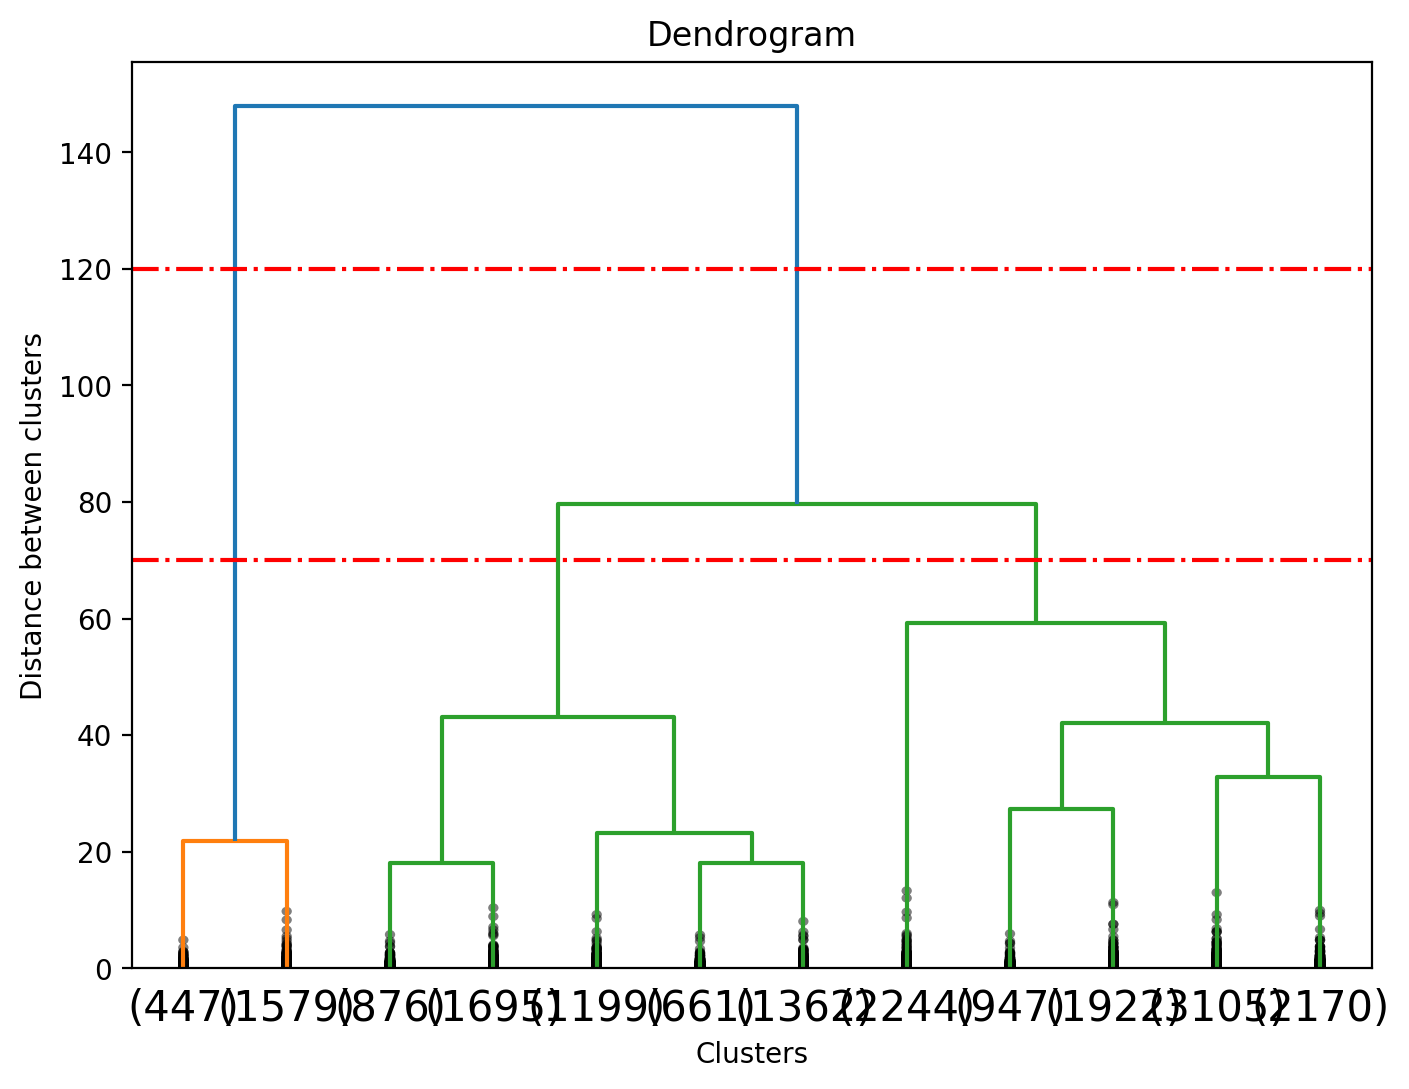

In [49]:
# Agglomerative

plt.figure(num=None, figsize=(8, 6), dpi=200)
distance_matrix = linkage(df[numeric], 'ward')
dendrogram(distance_matrix, truncate_mode='lastp', p=12, leaf_font_size=15, show_contracted=True)
plt.axhline(y=120, linestyle='-.', color='red')
plt.axhline(y=70, linestyle='-.', color='red')
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Distance between clusters')

In [50]:
# za podelu na 2 klastera

agglomerative = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agglomerative.fit(df[numeric])

AgglomerativeClustering()

In [51]:
count = Counter(agglomerative.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{0: [16181, 88.87241170978196], 1: [2026, 11.127588290218048]}

In [52]:
df['cluster_marks'] = agglomerative.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))


Broj igraca u klasteru 0: 16181, (88.87241170978196 %)

NAPAD: 3477 (21.48816513194487 %)
Broj igraca na poziciji RF: 16, (0.09888140411593845 %)
Broj igraca na poziciji LF: 15, (0.09270131635869229 %)
Broj igraca na poziciji RW: 370, (2.2866324701810767 %)
Broj igraca na poziciji LW: 381, (2.3546134355107844 %)
Broj igraca na poziciji ST: 2211, (13.664174031271244 %)
Broj igraca na poziciji CF: 74, (0.45732649403621534 %)
Broj igraca na poziciji RS: 203, (1.254557814720969 %)
Broj igraca na poziciji LS: 207, (1.2792781657499537 %)

VEZNI RED: 6838 (42.259440084049196 %)
Broj igraca na poziciji RDM: 248, (1.5326617637970459 %)
Broj igraca na poziciji CDM: 948, (5.858723193869353 %)
Broj igraca na poziciji LDM: 243, (1.5017613250108153 %)
Broj igraca na poziciji RM: 1124, (6.946418639144676 %)
Broj igraca na poziciji RCM: 391, (2.416414313083246 %)
Broj igraca na poziciji CM: 1394, (8.615042333601137 %)
Broj igraca na poziciji LCM: 395, (2.4411346641122305 %)
Broj igraca na poziciji LM:

In [53]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

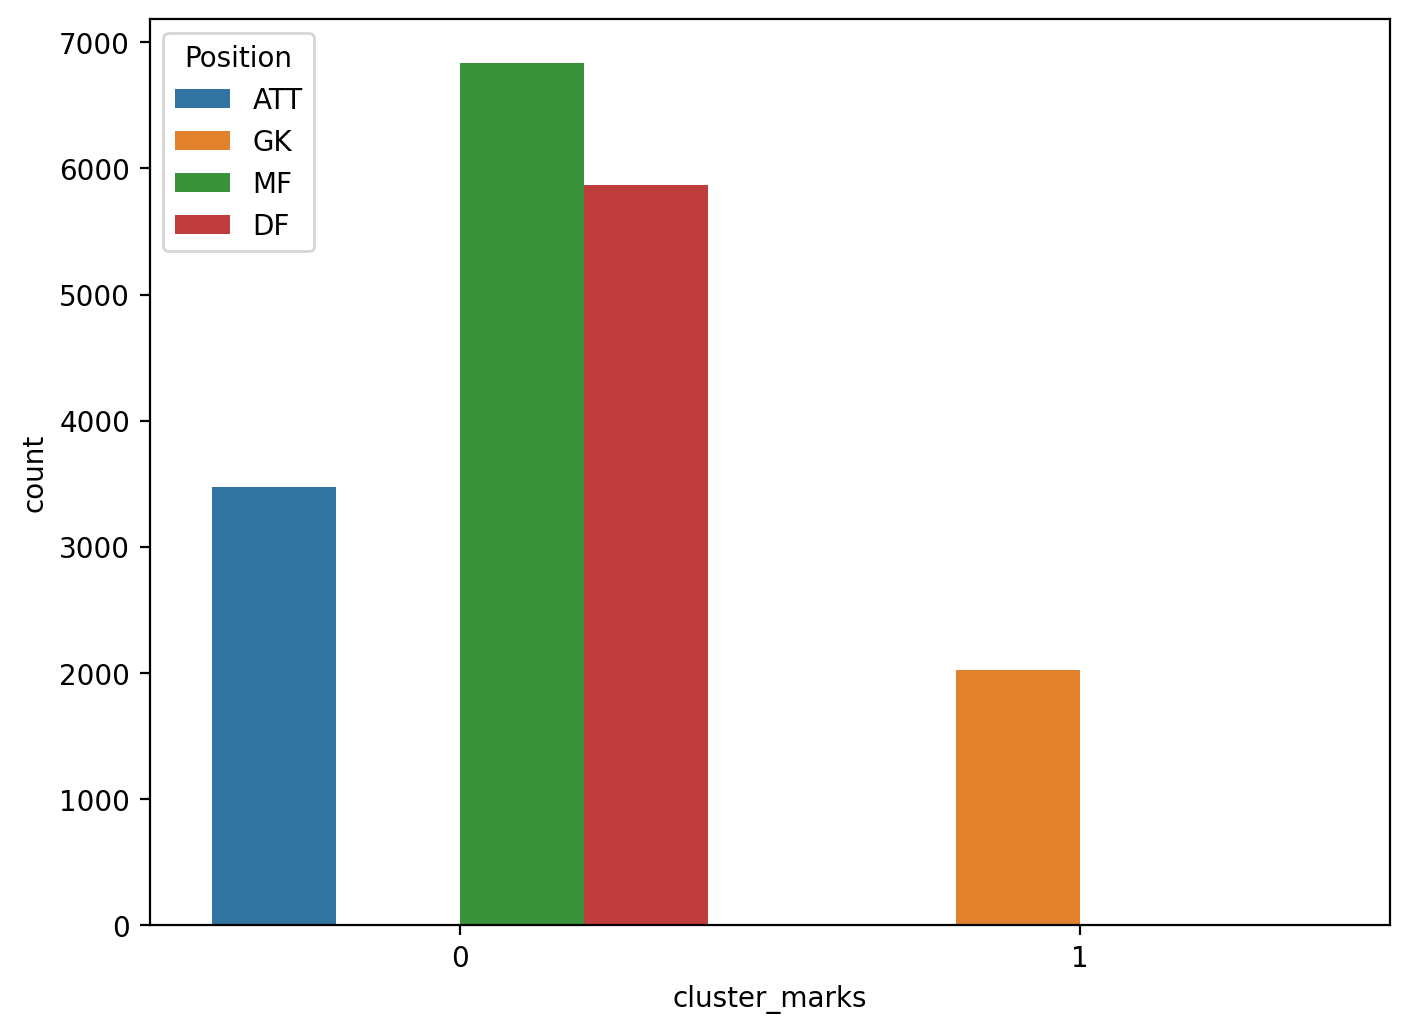

In [54]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)


In [55]:
# Za podelu na 3 klastera

agglomerative = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
agglomerative.fit(df[numeric])
clusters = agglomerative.labels_

count = Counter(clusters)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{0: [10388, 57.05497885428681],
 2: [5793, 31.817432855495138],
 1: [2026, 11.127588290218048]}

In [56]:
df['cluster_marks'] = agglomerative.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 1, len(df))

Broj igraca u klasteru 0: 10388, (57.05497885428681 %)

NAPAD: 1603 (15.431266846361186 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 2, (0.019252984212552945 %)
Broj igraca na poziciji RW: 164, (1.5787447054293418 %)
Broj igraca na poziciji LW: 167, (1.607624181748171 %)
Broj igraca na poziciji ST: 1137, (10.94532152483635 %)
Broj igraca na poziciji CF: 35, (0.3369272237196766 %)
Broj igraca na poziciji RS: 53, (0.5102040816326531 %)
Broj igraca na poziciji LS: 45, (0.4331921447824413 %)

VEZNI RED: 3695 (35.56988833269157 %)
Broj igraca na poziciji RDM: 134, (1.2899499422410472 %)
Broj igraca na poziciji CDM: 727, (6.998459761262995 %)
Broj igraca na poziciji LDM: 149, (1.4343473238351945 %)
Broj igraca na poziciji RM: 523, (5.034655371582596 %)
Broj igraca na poziciji RCM: 180, (1.7327685791297651 %)
Broj igraca na poziciji CM: 944, (9.08740854832499 %)
Broj igraca na poziciji LCM: 173, (1.6653831343858296 %)
Broj igraca na poziciji LM: 476, (4.58221024258760

In [57]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

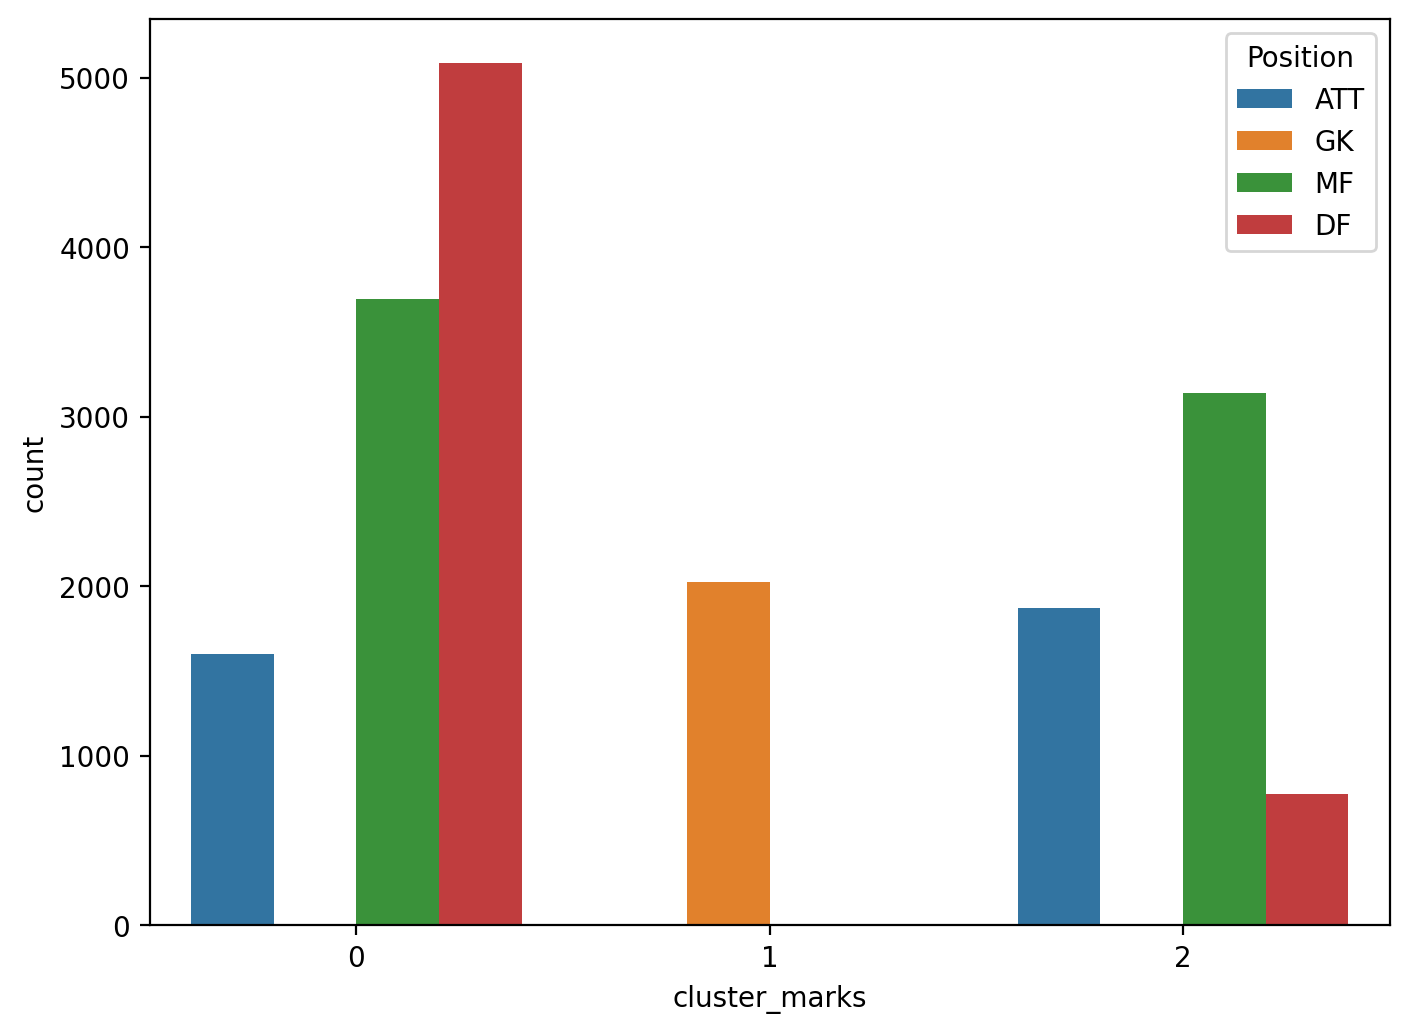

In [58]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [59]:
# DBSCAN

dbscan = DBSCAN()
dbscan.fit(df[numeric])

count = Counter(dbscan.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]

number_and_percentige_per_cluster    

{1: [10979, 60.30098313835338],
 -1: [5632, 30.933157576756194],
 0: [1546, 8.491239633108146],
 3: [7, 0.03844675124951942],
 2: [5, 0.027461965178228156],
 8: [5, 0.027461965178228156],
 5: [5, 0.027461965178228156],
 9: [4, 0.021969572142582522],
 6: [4, 0.021969572142582522],
 10: [4, 0.021969572142582522],
 11: [4, 0.021969572142582522],
 4: [3, 0.01647717910693689],
 7: [3, 0.01647717910693689],
 12: [3, 0.01647717910693689],
 13: [3, 0.01647717910693689]}

In [60]:
df['cluster_marks'] = dbscan.labels_

df_cluster_minus_1 = df.loc[df['cluster_marks'] == -1]
df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]
df_cluster_5 = df.loc[df['cluster_marks'] == 5]
df_cluster_6 = df.loc[df['cluster_marks'] == 6]
df_cluster_7 = df.loc[df['cluster_marks'] == 7]
df_cluster_8 = df.loc[df['cluster_marks'] == 8]
df_cluster_9 = df.loc[df['cluster_marks'] == 9]
df_cluster_10 = df.loc[df['cluster_marks'] == 10]
df_cluster_11 = df.loc[df['cluster_marks'] == 11]
df_cluster_12 = df.loc[df['cluster_marks'] == 12]
df_cluster_13 = df.loc[df['cluster_marks'] == 13]

show_position_percentige_per_cluster(df_cluster_minus_1, -1, len(df))
show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))
show_position_percentige_per_cluster(df_cluster_5, 5, len(df))
show_position_percentige_per_cluster(df_cluster_6, 6, len(df))
show_position_percentige_per_cluster(df_cluster_7, 7, len(df))
show_position_percentige_per_cluster(df_cluster_8, 8, len(df))
show_position_percentige_per_cluster(df_cluster_9, 9, len(df))
show_position_percentige_per_cluster(df_cluster_10, 10, len(df))
show_position_percentige_per_cluster(df_cluster_11, 11, len(df))
show_position_percentige_per_cluster(df_cluster_12, 12, len(df))
show_position_percentige_per_cluster(df_cluster_13, 13, len(df))

Broj igraca u klasteru -1: 5632, (30.933157576756194 %)

NAPAD: 1338 (23.757102272727273 %)
Broj igraca na poziciji RF: 8, (0.14204545454545456 %)
Broj igraca na poziciji LF: 9, (0.15980113636363638 %)
Broj igraca na poziciji RW: 155, (2.752130681818182 %)
Broj igraca na poziciji LW: 149, (2.645596590909091 %)
Broj igraca na poziciji ST: 803, (14.2578125 %)
Broj igraca na poziciji CF: 31, (0.5504261363636364 %)
Broj igraca na poziciji RS: 90, (1.5980113636363635 %)
Broj igraca na poziciji LS: 93, (1.6512784090909092 %)

VEZNI RED: 2062 (36.612215909090914 %)
Broj igraca na poziciji RDM: 63, (1.1186079545454546 %)
Broj igraca na poziciji CDM: 250, (4.438920454545454 %)
Broj igraca na poziciji LDM: 77, (1.3671875 %)
Broj igraca na poziciji RM: 399, (7.084517045454546 %)
Broj igraca na poziciji RCM: 97, (1.7223011363636365 %)
Broj igraca na poziciji CM: 286, (5.078125 %)
Broj igraca na poziciji LCM: 99, (1.7578125 %)
Broj igraca na poziciji LM: 403, (7.1555397727272725 %)
Broj igraca na p

GOLMANI: 5 (100.0 %)

Broj igraca u klasteru 9: 4, (0.021969572142582522 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 4 (100.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 2, (5

In [61]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

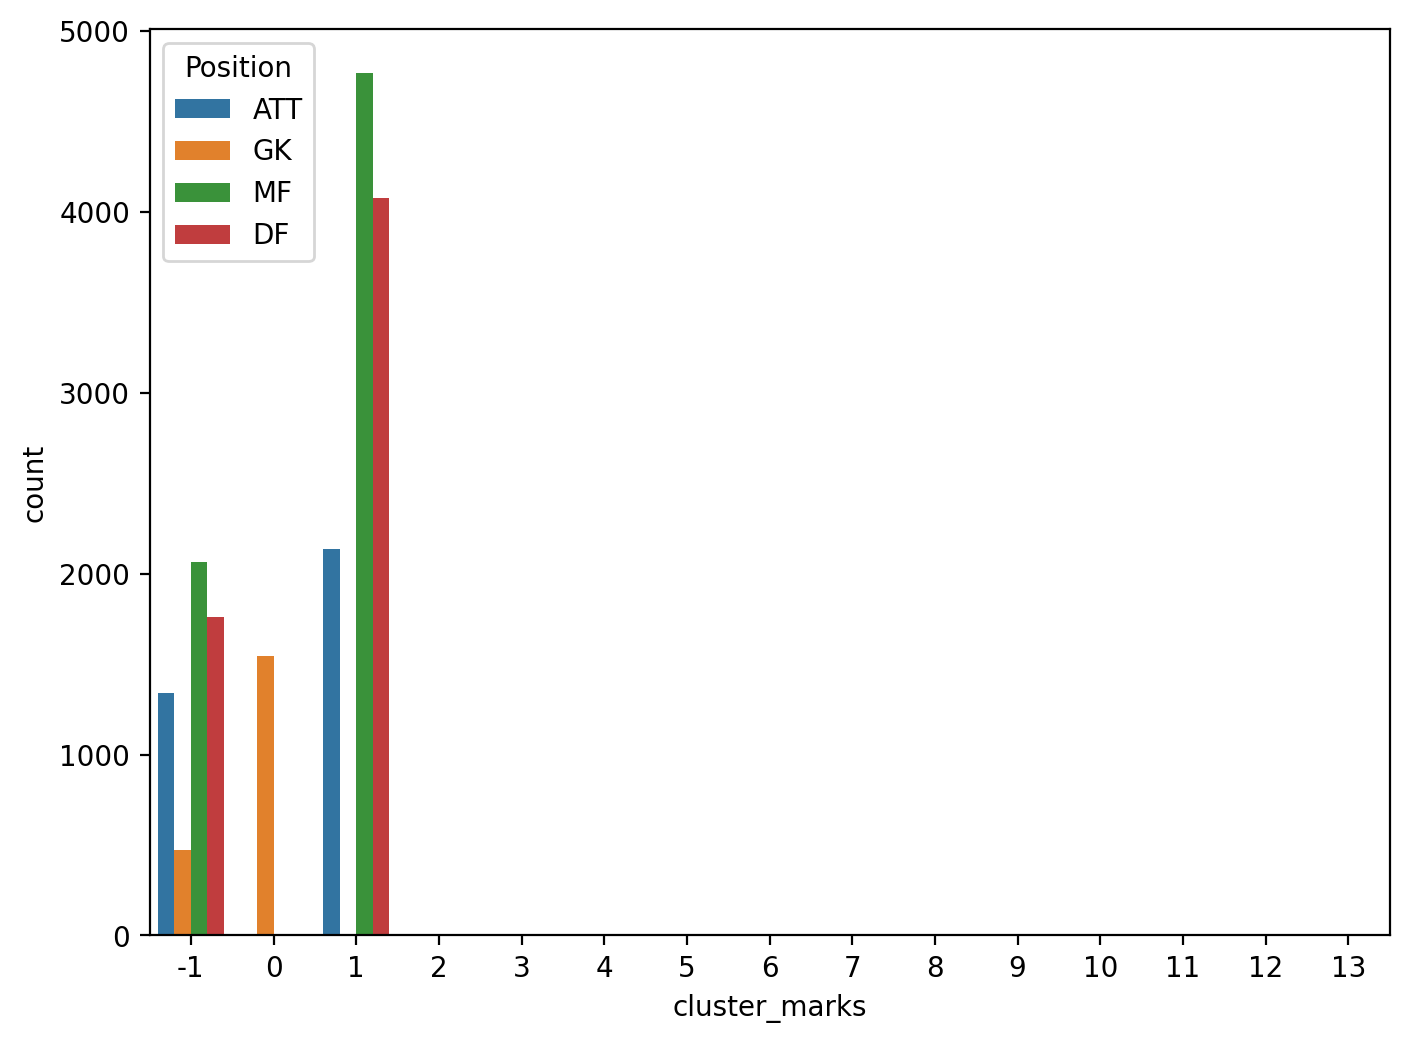

In [62]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [63]:
dbscan = DBSCAN(min_samples=6)
dbscan.fit(df[numeric])

count = Counter(dbscan.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{2: [10810, 59.37276871532927],
 -1: [5852, 32.141484044598236],
 0: [1526, 8.381391772395233],
 1: [6, 0.03295435821387378],
 3: [5, 0.027461965178228156],
 4: [4, 0.021969572142582522],
 5: [4, 0.021969572142582522]}

In [64]:
df['cluster_marks'] = dbscan.labels_

df_cluster_minus_1 = df.loc[df['cluster_marks'] == -1]
df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]
df_cluster_5 = df.loc[df['cluster_marks'] == 5]

show_position_percentige_per_cluster(df_cluster_minus_1, -1, len(df))
show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))
show_position_percentige_per_cluster(df_cluster_5, 5, len(df))

Broj igraca u klasteru -1: 5852, (32.141484044598236 %)

NAPAD: 1391 (23.769651401230348 %)
Broj igraca na poziciji RF: 8, (0.1367053998632946 %)
Broj igraca na poziciji LF: 9, (0.15379357484620643 %)
Broj igraca na poziciji RW: 165, (2.819548872180451 %)
Broj igraca na poziciji LW: 160, (2.734107997265892 %)
Broj igraca na poziciji ST: 821, (14.029391660970608 %)
Broj igraca na poziciji CF: 34, (0.5809979494190021 %)
Broj igraca na poziciji RS: 95, (1.6233766233766231 %)
Broj igraca na poziciji LS: 99, (1.6917293233082706 %)

VEZNI RED: 2130 (36.39781271360219 %)
Broj igraca na poziciji RDM: 65, (1.1107313738892686 %)
Broj igraca na poziciji CDM: 259, (4.425837320574163 %)
Broj igraca na poziciji LDM: 78, (1.3328776486671223 %)
Broj igraca na poziciji RM: 414, (7.0745044429254955 %)
Broj igraca na poziciji RCM: 101, (1.7259056732740943 %)
Broj igraca na poziciji CM: 289, (4.938482570061518 %)
Broj igraca na poziciji LCM: 100, (1.7088174982911826 %)
Broj igraca na poziciji LM: 423, (7.

In [65]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

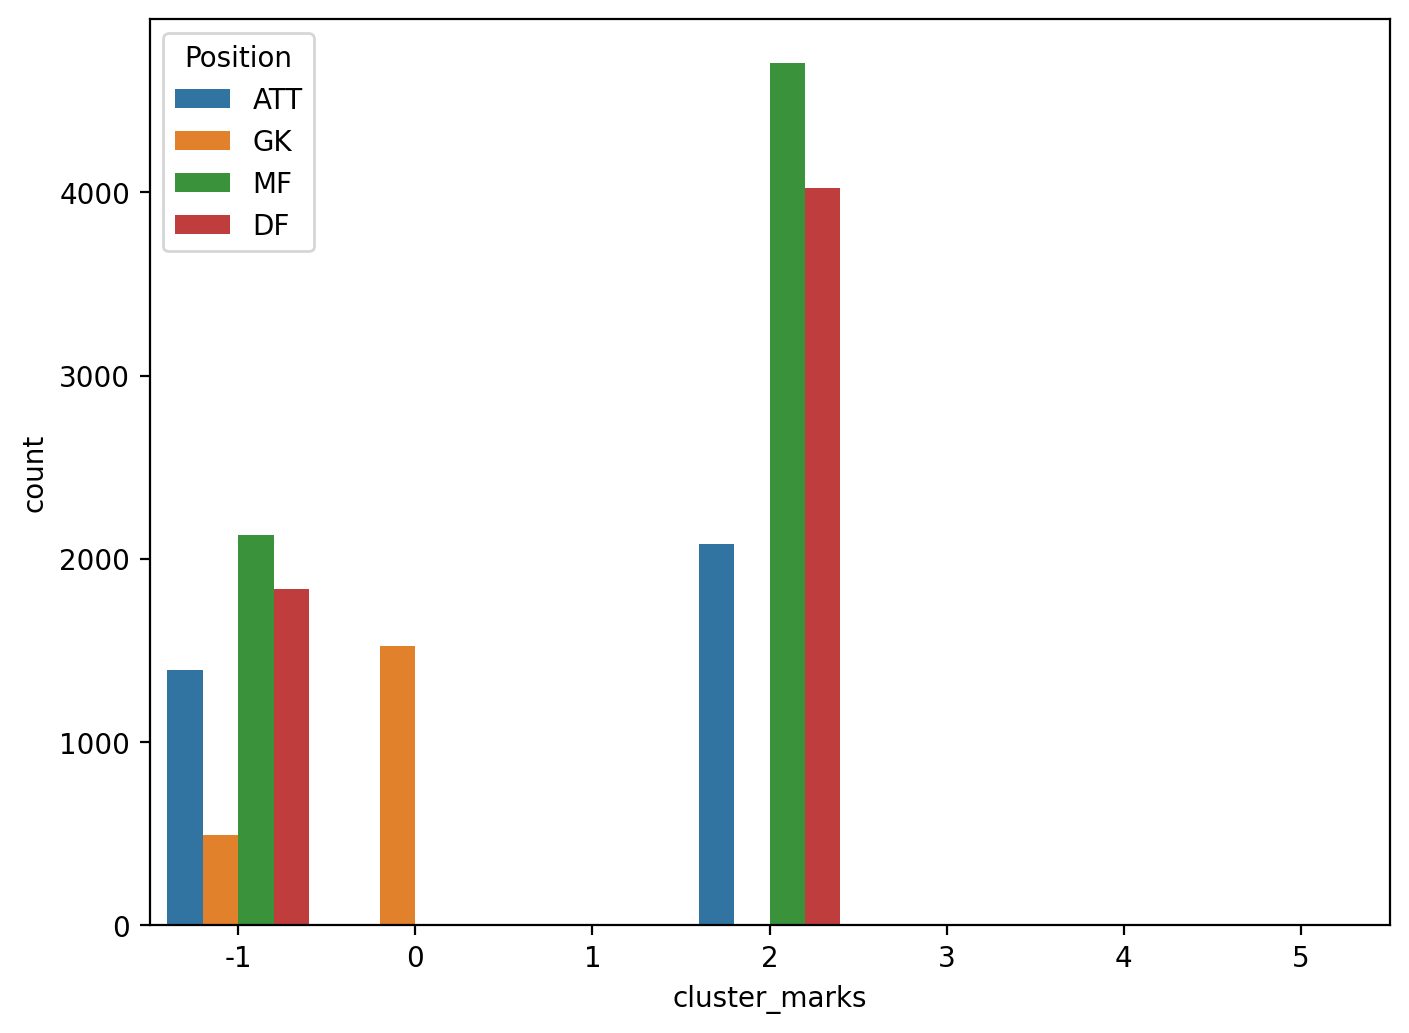

In [66]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [67]:
dbscan = DBSCAN(min_samples=7)
dbscan.fit(df[numeric])
dbscan.labels_

count = Counter(dbscan.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{1: [10636, 58.41709232712693],
 -1: [6049, 33.223485472620425],
 0: [1514, 8.315483055967485],
 2: [4, 0.021969572142582522],
 3: [4, 0.021969572142582522]}

In [68]:
df['cluster_marks'] = dbscan.labels_

df_cluster_minus_1 = df.loc[df['cluster_marks'] == -1]
df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]

show_position_percentige_per_cluster(df_cluster_minus_1, -1, len(df))
show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))

Broj igraca u klasteru -1: 6049, (33.223485472620425 %)

NAPAD: 1441 (23.822119358571666 %)
Broj igraca na poziciji RF: 8, (0.13225326500247975 %)
Broj igraca na poziciji LF: 9, (0.1487849231277897 %)
Broj igraca na poziciji RW: 175, (2.8930401719292447 %)
Broj igraca na poziciji LW: 167, (2.7607869069267648 %)
Broj igraca na poziciji ST: 844, (13.952719457761614 %)
Broj igraca na poziciji CF: 37, (0.6116713506364688 %)
Broj igraca na poziciji RS: 100, (1.653165812530997 %)
Broj igraca na poziciji LS: 101, (1.6696974706563068 %)

VEZNI RED: 2203 (36.419242850057856 %)
Broj igraca na poziciji RDM: 67, (1.1076210943957678 %)
Broj igraca na poziciji CDM: 266, (4.397421061332452 %)
Broj igraca na poziciji LDM: 80, (1.3225326500247974 %)
Broj igraca na poziciji RM: 433, (7.158207968259217 %)
Broj igraca na poziciji RCM: 103, (1.7027607869069268 %)
Broj igraca na poziciji CM: 300, (4.95949743759299 %)
Broj igraca na poziciji LCM: 103, (1.7027607869069268 %)
Broj igraca na poziciji LM: 437, (

In [69]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

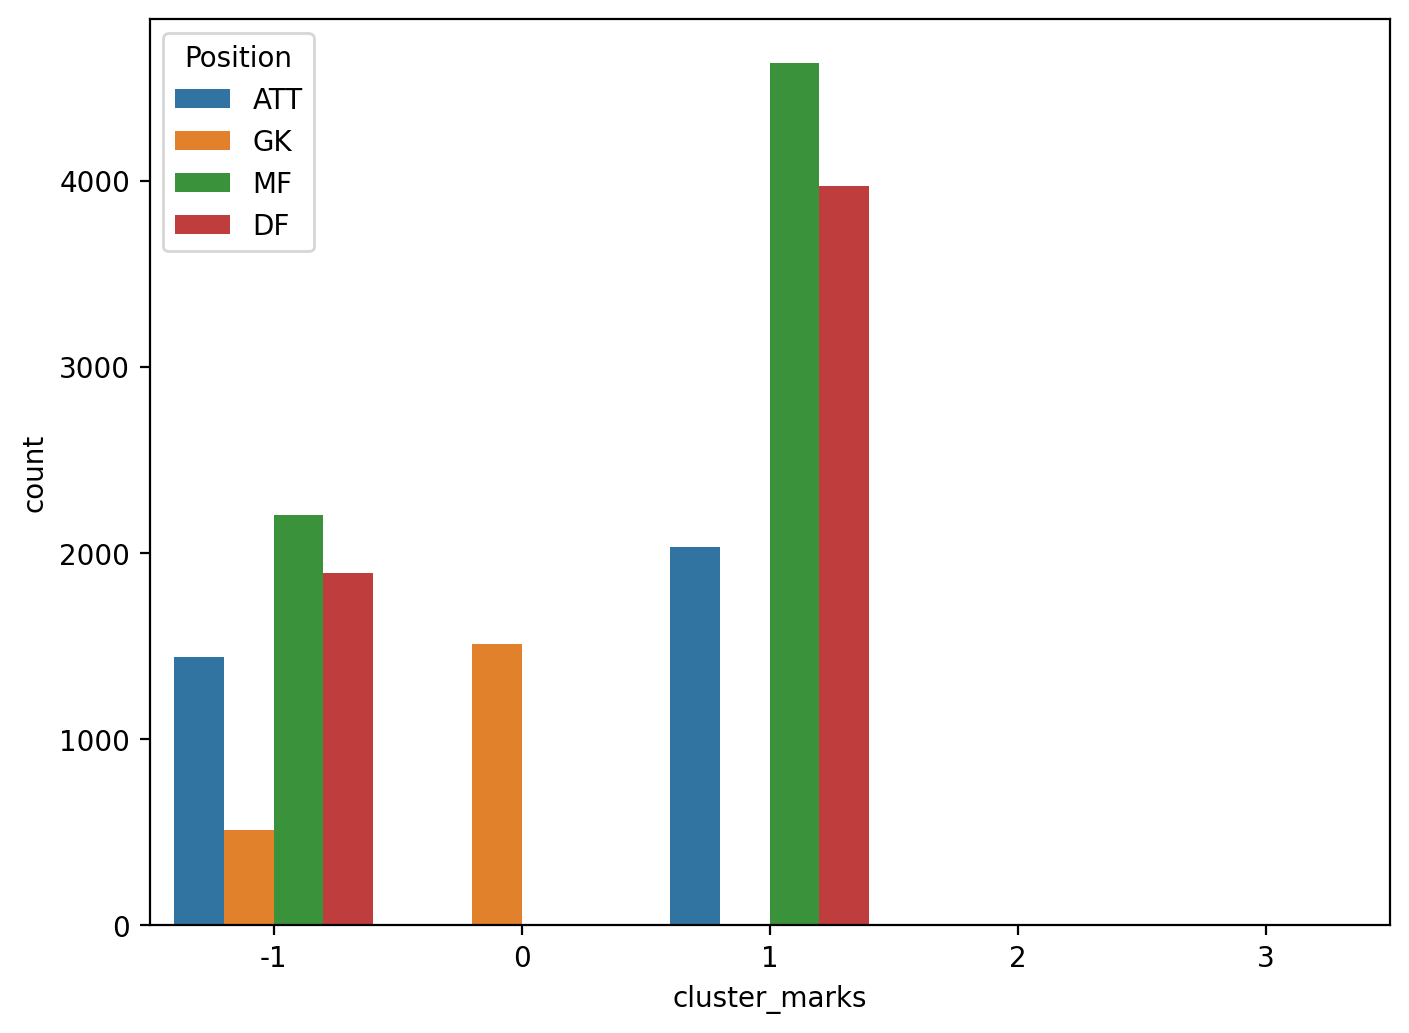

In [70]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)